In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [62]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

U ovom slučaju, koristi se samo deo podataka koji ima neku labelu, tj. samo toksični komentari. Njih je potrebno klasifikovati u 6 različitih klasa (sa preklapanjem).

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [5]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,word_count
6,cocksucker before you piss around on my work,1,1,1,0,1,0,1,8
12,hey what is it talk what is it an exclusive...,1,0,0,0,0,0,1,50
16,bye dont look come or think of comming back ...,1,0,0,0,0,0,1,10
42,you are gay or antisemmitian archangel white...,1,0,1,0,1,1,1,109
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,1,8


In [6]:
data.shape

(22468, 9)

Dakle, broj instanci za višelabelarnu klasifikaciju je 22468

### 1. Podela na trening, test, i validacioni skup

Ovde će podela biti odrađena ručno, jer je skup podataka mali. 

In [9]:
# train_test_split izbacuje gresku
# ValueError: The least populated class in y has only 1 member, 
# which is too few. The minimum number of groups for any class cannot be less than 2.

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['comment_text'], data[labels], test_size=0.33, random_state=7, stratify=data[labels])

In [10]:
test_size = int(0.3 * data.shape[0])
train_size = data.shape[0] - test_size
validation_size = int(0.2 * train_size)
train_size -= validation_size

In [11]:
train_data = data[:train_size]
validation_data = data[train_size : train_size + validation_size]
test_data = data[train_size+validation_size: ]

In [12]:
X_train = train_data['comment_text']
X_validation = validation_data['comment_text']
X_test = test_data['comment_text']

y_train = train_data[labels]
y_test = test_data[labels]
y_validation = validation_data[labels]

### 2. Tokenizacija I vektorizacija teksta

In [13]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [14]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_multi.pickle')

In [15]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 31832


In [16]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [17]:
X_train.shape, X_test.shape, X_validation.shape

((12583, 100), (6740, 100), (3145, 100))

In [18]:
# kreiranje matrice ugnjezdjavanja

embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Formiranje modela

Odmah se prelazi na formiranje modela, koristiće se isti parametri koji su izabrani kao najbolji za binarnu klasifikaciju.

In [86]:
kernel_size = 4
pool_size = 4
filters = 64
dropout_rate = 0.4
embedding_dim = 100
lr = 0.001

In [87]:
multi_model = create_model(num_of_classes = 6, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           25664     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 128)           32896     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 128)           

### 4. Obučavanje modela

In [85]:
# TODO weights


In [88]:
epochs = 15
batch_size = 64

In [89]:
start = time.time()    

multi_history = multi_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation))
                                #, class_weight=weights)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Epoch 1/15
197/197 [==============================] - 10s 34ms/step - loss: 0.3890 - accuracy: 0.9414 - f1_m: 0.7584 - val_loss: 0.3394 - val_accuracy: 0.9297 - val_f1_m: 0.7819
Epoch 2/15
197/197 [==============================] - 6s 30ms/step - loss: 0.3255 - accuracy: 0.9193 - f1_m: 0.8025 - val_loss: 0.3164 - val_accuracy: 0.9119 - val_f1_m: 0.7987
Epoch 3/15
197/197 [==============================] - 6s 28ms/step - loss: 0.3089 - accuracy: 0.8937 - f1_m: 0.8124 - val_loss: 0.3036 - val_accuracy: 0.8986 - val_f1_m: 0.8133
Epoch 4/15
197/197 [==============================] - 6s 28ms/step - loss: 0.2936 - accuracy: 0.8827 - f1_m: 0.8218 - val_loss: 0.2998 - val_accuracy: 0.8824 - val_f1_m: 0.8067
Epoch 5/15
197/197 [==============================] - 6s 28ms/step - loss: 0.2834 - accuracy: 0.8595 - f1_m: 0.8279 - val_loss: 0.3113 - val_accuracy: 0.8986 - val_f1_m: 0.7975
Epoch 6/15
197/197 [==============================] - 6s 28ms/step - loss: 0.2754 - accuracy: 0.8487 - f1_m: 0.834

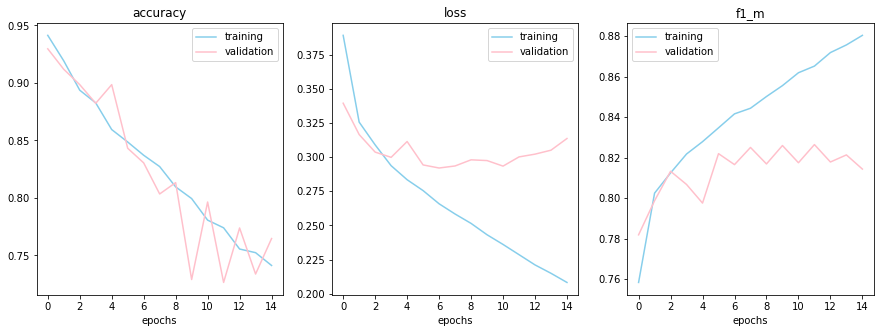

In [90]:
plot_graphs(multi_history, ['accuracy', 'loss', 'f1_m'])

### 5. Evaluacija modela

In [91]:
scores = multi_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

211/211 [==============================] - 2s 7ms/step - loss: 0.3085 - accuracy: 0.7868 - f1_m: 0.8210
Loss:  0.30854538083076477
Test accuracy:  0.7867952585220337
F1:  0.8209932446479797


Predviđanje:

In [92]:
y_predicted = multi_model.predict(X_test)

211/211 [==============================] - 2s 6ms/step


In [93]:
y_labels = y_predicted.round()

In [94]:
y_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0.]], dtype=float32)

In [95]:
cf = multilabel_confusion_matrix(y_test, y_labels)

In [96]:
label_counts = []
for label in labels:
    label_counts.append(y_test[y_test[label]==1].shape[0])

In [97]:
label_counts

[6567, 410, 3937, 229, 3658, 758]

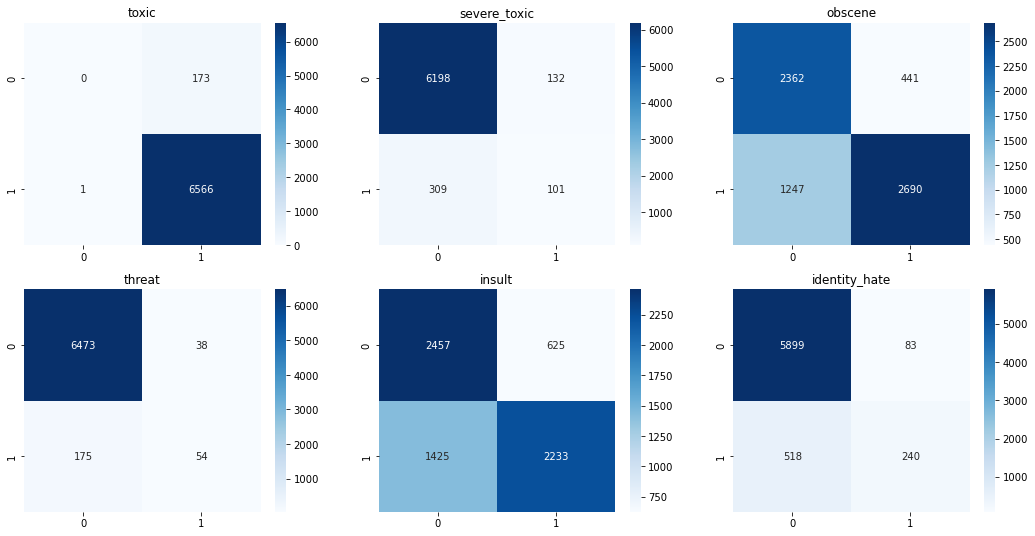

In [98]:
plot_cf(cf, 'multi', labels)

In [99]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels,
      target_names=labels))

---------------------- IZVESTAJ -----------------------

               precision    recall  f1-score   support

        toxic       0.97      1.00      0.99      6567
 severe_toxic       0.43      0.25      0.31       410
      obscene       0.86      0.68      0.76      3937
       threat       0.59      0.24      0.34       229
       insult       0.78      0.61      0.69      3658
identity_hate       0.74      0.32      0.44       758

    micro avg       0.89      0.76      0.82     15559
    macro avg       0.73      0.52      0.59     15559
 weighted avg       0.87      0.76      0.81     15559
  samples avg       0.91      0.80      0.81     15559

